In [22]:
import sys
sys.path.append('/Data/reds_dataset/6.8300-Computer-Vision/src')
from time import time
from models import basicVSR

from torchvision.io import read_image
from torchvision.utils import flow_to_image
from data_handlers.loading import VideoDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models.optical_flow import raft

from models.basicVSR.SPyNet import SPyNet

import torch

import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchvision.models.optical_flow import raft_large, raft_small
from torchvision.models.optical_flow import Raft_Large_Weights, Raft_Small_Weights

from models.optical_flow.FlowNetS import flownets


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
def get_spynet(pretrained):
        model=SPyNet()
        if pretrained:
            model_p=model.state_dict()
            pre_p=torch.load(pretrained)
            ppl=list(pre_p)
            for i,k in enumerate(model_p.keys()):
                if i<2:
                    continue
                model_p[k]=pre_p[ppl[i-2]]
            model.load_state_dict(model_p)
        return model



In [24]:
model_init = basicVSR(spynet_pretrained='../checkpoints/spynet_20210409-c6c1bd09.pth', pretrained_model = 'False', reset_spynet = 0)
model_pret = basicVSR(spynet_pretrained='../checkpoints/spynet_20210409-c6c1bd09.pth', pretrained_model='../checkpoints/basicvsr.pth',  reset_spynet = 0)

model_flownet = flownets(torch.load('../checkpoints/flownets_EPE1.951.pth.tar'))
model_flownet.eval()

FlowNetS(
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv3_1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv4_1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 512,

In [25]:
test_dataset = VideoDataset(
        lr_data_dir='../data/processed/train/train_sharp_bicubic/X4',
        hr_data_dir='../data/processed/train/train_sharp',
        rolling_window=3,
        is_test=True,
        is_small_test=True,
    )
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

criterion_mse = nn.MSELoss().to(device)

model_init = model_init.to(device)
model_pret = model_pret.to(device)
model_flownet = model_flownet.to(device)

model_init.is_mirror_extended = False
model_pret.is_mirror_extended = False

In [26]:
loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [27]:
lq, gt = next(iter(loader))

lq.shape

torch.Size([1, 3, 3, 176, 320])

### Try to exec flow with RAFT

In [29]:
model_raft = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model_raft = model_raft.eval()

model_raft_small = raft_small(weights=raft.Raft_Small_Weights.DEFAULT, progress=False).to(device)
model_raft_small = model_raft_small.eval()

Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /users/eleves-a/2019/paul.theron/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


In [41]:
# get the name of the module of model_raft
len(model_raft.state_dict().keys())

169

In [42]:
len(torch.load('../checkpoints/spynet_20210409-c6c1bd09.pth').keys())

60

In [ ]:
lq, gt = next(iter(loader))

lq = lq.to(device)
gt = gt.to(device)

# offset lq by 1 frame
lq_base = lq[:, 0, :, :, :].clone()
lq = lq[:, 1, :, :, :]


flows = model_raft(lq, lq_base)

NameError: name 'model_raft' is not defined

In [ ]:
flows[-1].shape

NameError: name 'flows' is not defined

In [ ]:
# this will plot many images

#fig, ax = plt.subplots(5,4, figsize=(20,20))
#for i in range(5):
#    for j in range(4):
#        img = lq[i*4+j].permute(1,2,0).cpu().detach().numpy()
#        ax[i][j].imshow(img)
#        ax[i][j].axis('off')

# Compare optical flow from our model

In [30]:
def flow_to_color(predicted_flows):
    flow_imgs = flow_to_image(predicted_flows)

    # The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
    # enhance the flow
    
    return flow_imgs.permute(1, 2, 0)

In [31]:
from torchvision import transforms

def compute_flow_flownet(lq):
    tf = transforms.Compose([
        transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
        transforms.Normalize(mean=[0.411,0.432,0.45], std=[1,1,1])
    ])
    lq = tf(lq)
    n, t, c, h, w = lq.size()

    img_1_flownet = lq[:, :-1, :, :, :].reshape(-1, c, h, w)
    img_2_flownet = lq[:, 1:, :, :, :].reshape(-1, c, h, w)

    input_flownet_fwd = torch.cat([img_1_flownet, img_2_flownet], dim = 1)
    input_flownet_bwd = torch.cat([img_2_flownet, img_1_flownet], dim = 1)

    predicted_flows_fwd = model_flownet(input_flownet_fwd)
    predicted_flows_bwd = model_flownet(input_flownet_bwd)

    predicted_flows_fwd = predicted_flows_fwd
    predicted_flows_bwd = predicted_flows_bwd
    
    # upsample the flow to the original size
    predicted_flows_fwd = nn.functional.interpolate(predicted_flows_fwd, size=(h, w), mode='bilinear', align_corners=False).reshape(n, t-1, 2, h, w)
    predicted_flows_bwd = nn.functional.interpolate(predicted_flows_bwd, size=(h, w), mode='bilinear', align_corners=False).reshape(n, t-1, 2, h, w)
    return predicted_flows_fwd, predicted_flows_bwd

def compute_flow_model_raft(lq):
    n, t, c, h, w = lq.size()

    img_1_flownet = lq[:, :-1, :, :, :].reshape(-1, c, h, w)
    img_2_flownet = lq[:, 1:, :, :, :].reshape(-1, c, h, w)

    predicted_flows_bwd = model_raft(img_1_flownet, img_2_flownet)[-1]
    predicted_flows_fwd = model_raft(img_2_flownet, img_1_flownet)[-1]

    predicted_flows_fwd = predicted_flows_fwd.reshape(n, t-1, 2, h, w)
    predicted_flows_bwd = predicted_flows_bwd.reshape(n, t-1, 2, h, w)
    return predicted_flows_fwd, predicted_flows_bwd

def compute_flow_model_raft_small(lq):
    n, t, c, h, w = lq.size()

    img_1_flownet = lq[:, :-1, :, :, :].reshape(-1, c, h, w)
    img_2_flownet = lq[:, 1:, :, :, :].reshape(-1, c, h, w)

    predicted_flows_bwd = model_raft_small(img_1_flownet, img_2_flownet)[-1]
    predicted_flows_fwd = model_raft_small(img_2_flownet, img_1_flownet)[-1]

    predicted_flows_fwd = predicted_flows_fwd.reshape(n, t-1, 2, h, w)
    predicted_flows_bwd = predicted_flows_bwd.reshape(n, t-1, 2, h, w)
    return predicted_flows_fwd, predicted_flows_bwd

In [32]:
(a,b) = compute_flow_model_raft(lq)

a.shape

torch.Size([1, 2, 2, 176, 320])

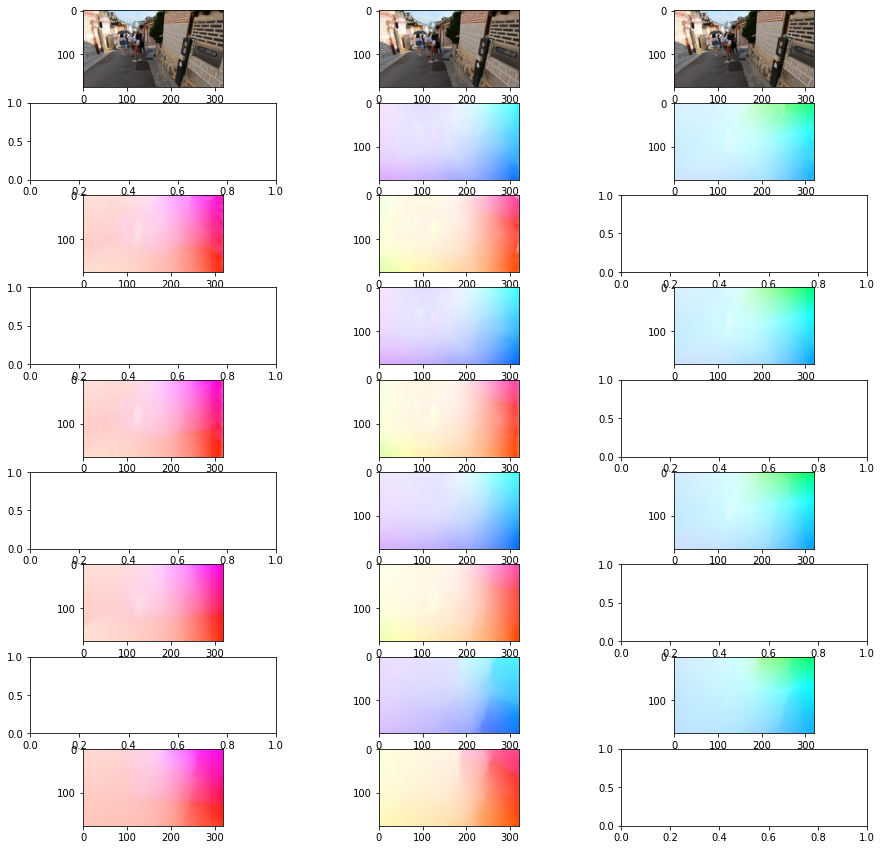

In [33]:
# print the images for the lq and the mdel init
lq, gt = next(iter(loader))

lq = lq.to(device)
gt = gt.to(device)

flow_fwd, flow_bwd = model_init.compute_flow(lq)

# display flow_fwd as an image
# display flow_bwd as an image

# print the images for the lq and the mdel pret
flow_fwd_pret, flow_bwd_pret = model_pret.compute_flow(lq)

flow_fwd_raft, flow_bwd_raft = compute_flow_model_raft(lq)

flow_fwd_raft_small, flow_bwd_raft_small = compute_flow_model_raft_small(lq)


fig, axs = plt.subplots(9, 3, figsize=(15, 15))

# on the first row, display the 3 images of the lq
axs[0, 0].imshow(lq[0, 0, :, :].permute(1, 2, 0).cpu().detach().numpy())
axs[0, 1].imshow(lq[0, 1, :, :].permute(1, 2, 0).cpu().detach().numpy())
axs[0, 2].imshow(lq[0, 2, :, :].permute(1, 2, 0).cpu().detach().numpy())

#second row, plot the flow_fwd
axs[1,1].imshow(flow_to_color(flow_fwd[0, 0, :, :].cpu().detach()))
axs[1,2].imshow(flow_to_color(flow_fwd[0, 1, :, :].cpu().detach()))

# third row, plot the flow_bwd
axs[2,1].imshow(flow_to_color(flow_bwd[0, 0, :, :].cpu().detach()))
axs[2,0].imshow(flow_to_color(flow_bwd[0, 1, :, :].cpu().detach()))

# fourth row, plot the flow_fwd_pret
axs[3,1].imshow(flow_to_color(flow_fwd_pret[0, 0, :, :].cpu().detach()))
axs[3,2].imshow(flow_to_color(flow_fwd_pret[0, 1, :, :].cpu().detach()))

# fifth row, plot the flow_bwd_pret
axs[4,1].imshow(flow_to_color(flow_bwd_pret[0, 0, :, :].cpu().detach()))
axs[4,0].imshow(flow_to_color(flow_bwd_pret[0, 1, :, :].cpu().detach()))

# sixth row, plot the flow_fwd_flownet
axs[5,1].imshow(flow_to_color(flow_fwd_raft[0, 0, :, :].cpu().detach()))
axs[5,2].imshow(flow_to_color(flow_fwd_raft[0, 1, :, :].cpu().detach()))

# seventh row, plot the flow_bwd_flownet
axs[6,1].imshow(flow_to_color(flow_bwd_raft[0, 0, :, :].cpu().detach()))
axs[6,0].imshow(flow_to_color(flow_bwd_raft[0, 1, :, :].cpu().detach()))

# eighth row, plot the flow_fwd_flownet_small
axs[7,1].imshow(flow_to_color(flow_fwd_raft_small[0, 0, :, :].cpu().detach()))
axs[7,2].imshow(flow_to_color(flow_fwd_raft_small[0, 1, :, :].cpu().detach()))

# ninth row, plot the flow_bwd_flownet_small
axs[8,1].imshow(flow_to_color(flow_bwd_raft_small[0, 0, :, :].cpu().detach()))
axs[8,0].imshow(flow_to_color(flow_bwd_raft_small[0, 1, :, :].cpu().detach()))


In [34]:
# calculate the psnr between the flows of the init model and the pret model
psnr_fwd = 10 * torch.log10(1 / criterion_mse(flow_fwd, flow_fwd_pret))
psnr_bwd = 10 * torch.log10(1 / criterion_mse(flow_bwd, flow_bwd_pret))

print(psnr_fwd)
print(psnr_bwd)

tensor(18.0871, grad_fn=<MulBackward0>)
tensor(14.3559, grad_fn=<MulBackward0>)
